In [2]:
import traceback

import numpy as np
import pandas as pd
from IPython.core.display_functions import display
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3 as db

import xml.etree.cElementTree as et


sns.set_context('paper')

In [3]:
def process_xml_columns(df_new_cols, cols, match, xml_col):
    path = match[xml_col]
    if path is not None:
        root = et.fromstring(path)
        try:
            temp_column_list = []
            for column in cols:
                row_elements = root.findall('.//{}'.format(column))
                row_list = []
                for row in row_elements:
                    row_list.append(row.text)
                temp_column_list.append(row_list)
            df = pd.DataFrame(temp_column_list)
            df = df.transpose()
            df.columns = df_new_cols
            df['match_api_id'] = match.match_api_id
            return df
        except Exception as e:
            print(e)


def create_new_df_from_xml(df, xml_column, df_cols, df_new_cols):
    new_df = pd.DataFrame()
    for index, row in df[df[xml_column].notna()].iterrows():
        df = process_xml_columns(df_new_cols, df_cols, row, xml_column)
        new_df = pd.concat([new_df, df], ignore_index=True)
    return new_df


def fill_nan_goals(df, col1, col2):
    df_col1_nan = df.loc[df[col1].isna()]
    df_col2_nan = df.loc[df[col2].isna()]
    for index, row in df_col1_nan.iterrows():
        avg_mean = df.loc[df.home_team == row.home_team][col1].mean()
        if avg_mean == avg_mean:
            df.loc[df.match_api_id == row.match_api_id, col1] = round(avg_mean)
        else:
            df.loc[df.match_api_id == row.match_api_id, col1] = 0
    for index, row in df_col2_nan.iterrows():
        avg_mean = df.loc[df.away_team == row.away_team][col2].mean()
        if avg_mean == avg_mean:
            df.loc[df.match_api_id == row.match_api_id, col2] = round(avg_mean)
        else:
            df.loc[df.match_api_id == row.match_api_id, col1] = 0
    return df


def missin_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df

def get_winner(row):
    if row['result_match'] == 'H':
        m_winner = row['home_team']
    elif row['home_team_goal'] == 'D':
        m_winner = 'Draw'
    else:
        m_winner = row['away_team']
    return m_winner


def get_points(row, team):
    if row['home_team'] == team:
        if row['result_match']== 'H':
            return 3
        elif row['result_match'] == 'A':
            return 0
        else:
            return 1
    else:
        if row['home_team_goal'] == 'H':
            return 0
        elif row['home_team_goal'] == 'A':
            return 3
        else:
            return 1

In [4]:
conn = db.connect('eu_soccer_database/database.sqlite')
chunk_size = 5000
batch_no = 1
for chunk in pd.read_sql("SELECT m.match_api_id,"
                         " Country.name AS country_name,"
                         " League.name AS league_name,"
                         " season,"
                         " stage,"
                         " m.date,"
                         " HT.team_long_name AS  home_team,"
                         " AT.team_long_name AS away_team,"
                         " home_team_goal,"
                         " away_team_goal,"
                         " m.possession,"
                         " CASE"
                         " WHEN m.home_team_goal > m.away_team_goal THEN 'H'"
                         " WHEN m.home_team_goal < m.away_team_goal THEN 'A'"
                         " WHEN m.home_team_goal = m.away_team_goal THEN 'D'"
                         " END AS result_match,"
                         " m.B365H,"
                         " m.B365D,"
                         " m.B365A,"
                         " m.BWH,"
                         " m.BWD,"
                         " m.BWA,"
                         " m.IWH,"
                         " m.IWD,"
                         " m.IWA,"
                         " m.LBH,"
                         " m.LBD,"
                         " m.LBA,"
                         " m.PSH,"
                         " m.PSD,"
                         " m.PSA,"
                         " m.WHH,"
                         " m.WHD,"
                         " m.WHA"
                         " FROM Match as m"
                         " JOIN Country on Country.id = m.country_id"
                         " JOIN League on League.id = m.league_id"
                         " LEFT JOIN Team AS HT on HT.team_api_id = m.home_team_api_id"
                         " LEFT JOIN Team AS AT on AT.team_api_id = m.away_team_api_id"
                         " LEFT JOIN Player AS H6 on H6.player_api_id = m.home_player_6"
                         " LEFT JOIN Player AS H7 on H7.player_api_id = m.home_player_7"
                         " LEFT JOIN Player AS H8 on H8.player_api_id = m.home_player_8"
                         " LEFT JOIN Player AS H9 on H9.player_api_id = m.home_player_9"
                         " LEFT JOIN Player AS H10 on H10.player_api_id = m.home_player_10"
                         " LEFT JOIN Player AS H11 on H11.player_api_id = m.home_player_11"
                         " LEFT JOIN Player AS A6 on A6.player_api_id = m.away_player_6"
                         " LEFT JOIN Player AS A7 on A7.player_api_id = m.away_player_7"
                         " LEFT JOIN Player AS A8 on A8.player_api_id = m.away_player_8"
                         " LEFT JOIN Player AS A9 on A9.player_api_id = m.away_player_9"
                         " LEFT JOIN Player AS A10 on A10.player_api_id = m.away_player_10"
                         " LEFT JOIN Player AS A11 on A11.player_api_id = m.away_player_11"
                         " WHERE League.id IN (1729, 4769, 7809, 10257, 21518)"
                         " AND m.possession IS NOT NULL"
                         " ORDER by date;", conn, chunksize=chunk_size):
    chunk.to_csv('chunk_data/chunk' + str(batch_no) + '.csv', index=False)
    batch_no += 1

In [5]:
df_detailed_matches = pd.read_csv('chunk_data/chunk1.csv')

In [6]:
profile = ProfileReport(df_detailed_matches, title='Detailed matches', minimal=True)
profile.to_file(output_file="report/first_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_detailed_matches['date'] = pd.to_datetime(df_detailed_matches['date']).dt.date
df_detailed_matches[
    ['country_name', 'league_name', 'season', 'home_team', 'away_team', 'result_match', 'possession']] = df_detailed_matches[
    ['country_name', 'league_name', 'season', 'home_team', 'away_team', 'result_match', 'possession']].astype('category')

In [8]:
df_detailed_matches = df_detailed_matches.drop(['PSH', 'PSD', 'PSA'], axis=1)

In [9]:
teams = pd.unique(df_detailed_matches[['home_team', 'away_team']].values.ravel('K'))

In [10]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        matches = df_detailed_matches.loc[mask_team_matches]
        matches = matches.sort_values(by='date')

        for index, row in matches.iterrows():
            previous_match_goals = row['home_team_goal'] if team == row['home_team'] else row['away_team_goal']
            last_match = matches.loc[matches['match_api_id'].shift(1) == row['match_api_id']].dropna(how='all')
            if not last_match.empty:
                if team == last_match['home_team'].values:
                    df_detailed_matches.loc[
                        df_detailed_matches['match_api_id'] == last_match.iloc[0]['match_api_id'], 'lm_goals_home'] = previous_match_goals
                else:
                    df_detailed_matches.loc[
                        df_detailed_matches['match_api_id'] == last_match.iloc[0]['match_api_id'], 'lm_goals_away'] = previous_match_goals
except Exception as e:
    e.with_traceback()
    print(e)

df_detailed_matches = fill_nan_goals(df_detailed_matches, 'lm_goals_home', 'lm_goals_away')
df_detailed_matches.lm_goals_home = df_detailed_matches.lm_goals_home.astype(int)
df_detailed_matches.lm_goals_away = df_detailed_matches.lm_goals_away.astype(int)

In [11]:
try:
    for team in teams:
        mask_find_team_matches = (df_detailed_matches['home_team'] == team) | (
                df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_find_team_matches]
        team_matches = team_matches.sort_values(by='date')

        for index, row in team_matches.iterrows():
            mask_home = ((team_matches['home_team'] == row['home_team']) & (team_matches['date'] < row['date']))
            mask_away = ((team_matches['away_team'] == row['away_team']) & (team_matches['date'] < row['date']))
            mask_both = (team_matches['date'] < row['date'])

            avg_l5m_hh = team_matches.loc[mask_home].iloc[-5:]['home_team_goal'].mean()
            avg_l5m_aa = team_matches.loc[mask_away].iloc[-5:]['away_team_goal'].mean()
            l5_m = team_matches.loc[mask_both].iloc[-5:]

            goals = []

            for idx, r in l5_m.iterrows():
                if r['home_team'] == team:
                    goals.append(r['home_team_goal'])
                else:
                    goals.append(r['away_team_goal'])

            avg_l5_m = np.nan if len(goals) == 0 else sum(goals) / len(goals)
            if team == row['home_team']:
                if pd.isna(avg_l5m_aa):
                    avg_l5m_aa = row['home_team_goal']
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_hh'] = avg_l5m_hh
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_h'] = avg_l5_m
            else:
                if pd.isna(avg_l5m_aa):
                    avg_l5m_aa = row['away_team_goal']
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_aa'] = avg_l5m_aa
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_a'] = avg_l5_m
except Exception as e:
    print(e)

df_detailed_matches = fill_nan_goals(df_detailed_matches, 'avg_l5m_h', 'avg_l5m_hh')
df_detailed_matches = fill_nan_goals(df_detailed_matches, 'avg_l5m_a', 'avg_l5m_aa')

In [12]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_team_matches]
        team_matches = team_matches.sort_values(by='date', ascending=False)

        for index, row in team_matches.iterrows():
            mask_both = (team_matches['date'] < row['date'])
            matches_filtering_by_date = team_matches.loc[mask_both]
            win_counter = 0

            for idx in range(len(matches_filtering_by_date)):
                if team == matches_filtering_by_date.iloc[idx]['home_team']:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] > match_goals.loc['away_team_goal']:
                        win_counter = win_counter + 1
                    else:
                        break
                else:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] < match_goals.loc['away_team_goal']:
                        win_counter = win_counter + 1
                    else:
                        break
            if team == row['home_team']:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_wh'] = win_counter
            else:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_wa'] = win_counter
except Exception as e:
    print(e)

In [13]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_team_matches]
        team_matches = team_matches.sort_values(by='date', ascending=False)

        for index, row in team_matches.iterrows():
            mask_both = (team_matches['date'] < row['date'])
            matches_filtering_by_date = team_matches.loc[mask_both]
            lose_counter = 0

            for idx in range(len(matches_filtering_by_date)):
                if team == matches_filtering_by_date.iloc[idx]['home_team']:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] > match_goals.loc['away_team_goal']:
                        break
                    else:
                        lose_counter = lose_counter + 1
                else:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] < match_goals.loc['away_team_goal']:
                        break
                    else:
                        lose_counter = lose_counter + 1

            if team == row['home_team']:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_lh'] = lose_counter
            else:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_la'] = lose_counter
except Exception as e:
    print(e)

df_detailed_matches.streak_last_la = df_detailed_matches.streak_last_la.astype(int)
df_detailed_matches.streak_last_lh = df_detailed_matches.streak_last_lh.astype(int)

df_detailed_matches.streak_last_wh = df_detailed_matches.streak_last_wh.astype(int)
df_detailed_matches.streak_last_wa = df_detailed_matches.streak_last_wa.astype(int)

In [14]:
columns_possession = ['awaypos', 'homepos', 'subtype', 'elapsed']
new_columns_possession = ['awaypos', 'homepos', 'subtype', 'elapsed']
df_possession = create_new_df_from_xml(df_detailed_matches, 'possession', columns_possession, new_columns_possession)

In [15]:
df_possession[['awaypos', 'homepos']] = df_possession[['awaypos', 'homepos']].fillna(0).astype('int')
df_possession[['awaypos', 'homepos']] = df_possession[['awaypos', 'homepos']].replace(0, np.nan)
df_possession['awaypos'] = df_possession['awaypos'].fillna(df_possession.groupby('match_api_id')['awaypos'].transform('mean'))
df_possession['homepos'] = df_possession['homepos'].fillna(df_possession.groupby('match_api_id')['homepos'].transform('mean'))
df_possession[['awaypos', 'homepos']] = df_possession[['awaypos', 'homepos']].astype('int')

In [16]:
df_possession = df_possession.loc[(df_possession['elapsed'] == '90') | df_possession['elapsed'].isna()]
df_possession = df_possession.groupby(by=['match_api_id'])[['awaypos', 'homepos']].mean().astype(int)
df_possession = df_possession.reset_index(level=0)

In [17]:
df_detailed_matches = pd.merge(df_detailed_matches, df_possession, how='left', on='match_api_id')

In [18]:
df_detailed_matches_nan_possession = df_detailed_matches.loc[(df_detailed_matches['awaypos'].isna()) | (df_detailed_matches['homepos'].isna())]

In [19]:
for index, row in df_detailed_matches_nan_possession.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    mask_all_matches_between_teams = ((df_detailed_matches['home_team'] == home_team) | (df_detailed_matches['away_team'] == home_team)) &\
                                     ((df_detailed_matches['home_team'] == away_team) | (df_detailed_matches['away_team'] == away_team))
    all_matches_between_teams = df_detailed_matches.loc[mask_all_matches_between_teams]

    home_possessions = []
    away_possessions = []

    for idx, r in all_matches_between_teams.iterrows():
        if (r['home_team'] == home_team) & (not pd.isna(r['homepos'])):
            home_possessions.append(r['homepos'])
        elif (r['away_team'] == home_team) & (not pd.isna(r['awaypos'])):
            home_possessions.append(r['awaypos'])

        if (r['home_team'] == away_team) & (not pd.isna(r['homepos'])):
            away_possessions.append(r['homepos'])
        elif (r['away_team'] == away_team) & (not pd.isna(r['awaypos'])):
            away_possessions.append(r['awaypos'])

    if (len(home_possessions) == 0) | (len(away_possessions) == 0):
        res = df_detailed_matches.drop(df_detailed_matches[df_detailed_matches.match_api_id == row.match_api_id].index)
    else:
        avg_possession_home = sum(home_possessions) / len(home_possessions)
        avg_possession_away = sum(away_possessions) / len(away_possessions)
        df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'homepos'] = int(avg_possession_home)
        df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'awaypos'] = int(avg_possession_away)

df_detailed_matches['awaypos'] = df_detailed_matches['awaypos'].fillna(df_detailed_matches.groupby(['away_team'])['awaypos'].transform('mean'))
df_detailed_matches['homepos'] = df_detailed_matches['homepos'].fillna(df_detailed_matches.groupby(['home_team'])['homepos'].transform('mean'))

df_detailed_matches['awaypos'] = df_detailed_matches['awaypos'].fillna(df_detailed_matches.groupby(['league_name'])['awaypos'].transform('mean'))
df_detailed_matches['homepos'] = df_detailed_matches['homepos'].fillna(df_detailed_matches.groupby(['league_name'])['homepos'].transform('mean'))

In [20]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        matches = df_detailed_matches.loc[mask_team_matches]
        matches = matches.sort_values(by='date')

        for index, row in matches.iterrows():
            previous_match_possession = row['homepos'] if team == row['home_team'] else row['awaypos']
            last_match = matches.loc[matches['match_api_id'].shift(1) == row['match_api_id']].dropna(how='all')

            if not last_match.empty:
                if team == last_match['home_team'].values:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == last_match['match_api_id'].values[0],
                                            'last_match_possession_home'] = previous_match_possession
                else:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == last_match['match_api_id'].values[0],
                                            'last_match_possession_away'] = previous_match_possession
except Exception as e:
    print(e)

df_detailed_matches['last_match_possession_away'] = df_detailed_matches['last_match_possession_away'].fillna(
    df_detailed_matches.groupby(['away_team'])['last_match_possession_away'].transform('mean'))
df_detailed_matches['last_match_possession_home'] = df_detailed_matches['last_match_possession_home'].fillna(
    df_detailed_matches.groupby(['home_team'])['last_match_possession_home'].transform('mean'))

df_detailed_matches['last_match_possession_away'] = df_detailed_matches['last_match_possession_away'].fillna(
    df_detailed_matches.groupby(['league_name'])['last_match_possession_away'].transform('mean'))
df_detailed_matches['last_match_possession_home'] = df_detailed_matches['last_match_possession_home'].fillna(
    df_detailed_matches.groupby(['league_name'])['last_match_possession_home'].transform('mean'))

df_detailed_matches.last_match_possession_home = df_detailed_matches.last_match_possession_home.astype(int)
df_detailed_matches.last_match_possession_away = df_detailed_matches.last_match_possession_away.astype(int)

In [21]:
df_detailed_matches = df_detailed_matches.drop(['homepos', 'awaypos'], axis=1)

In [22]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        matches = df_detailed_matches.loc[mask_team_matches]
        matches = matches.sort_values(by='date')

        for index, row in matches.iterrows():
            match_date = row['date']
            next_match = matches.loc[matches['match_api_id'].shift(1) == row['match_api_id']].dropna(how='all')

            if not next_match.empty:
                days_last_match = delta = next_match['date'].iloc[0] - match_date

                if team == next_match.iloc[0]['home_team']:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == next_match['match_api_id'].values[0],
                                            'days_since_lmh'] = days_last_match.days
                else:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == next_match['match_api_id'].values[0],
                                            'days_since_lma'] = days_last_match.days

except Exception as e:
    print(e)

df_detailed_matches['days_since_lmh'] = df_detailed_matches['days_since_lmh'].fillna(
    df_detailed_matches.groupby(['league_name'])['days_since_lmh'].transform('mean').astype(int))

df_detailed_matches['days_since_lma'] = df_detailed_matches['days_since_lma'].fillna(
    df_detailed_matches.groupby(['league_name'])['days_since_lma'].transform('mean').astype(int))

df_detailed_matches.days_since_lma = df_detailed_matches.days_since_lma.astype(int)
df_detailed_matches.days_since_lmh = df_detailed_matches.days_since_lmh.astype(int)

In [23]:
for index, row in df_detailed_matches.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    mask_all_matches_between_teams = ((df_detailed_matches['home_team'] == home_team) | (df_detailed_matches['away_team'] == home_team)) &\
                                     ((df_detailed_matches['home_team'] == away_team) | (df_detailed_matches['away_team'] == away_team))
    all_matches_between_teams = df_detailed_matches.loc[mask_all_matches_between_teams]

    for idx, r in all_matches_between_teams.iterrows():
        last_match = all_matches_between_teams.loc[all_matches_between_teams['match_api_id'].shift(1) == r['match_api_id']].dropna(how='all')
        m_winner = ''
        if not last_match.empty:
            m_winner = get_winner(r)

            match_api_id_ = df_detailed_matches['match_api_id'] == last_match.iloc[0]['match_api_id']
            df_detailed_matches.loc[match_api_id_, 'lm_winner'] = m_winner

In [24]:
df_detailed_matches_nan_lm_winner = df_detailed_matches.loc[df_detailed_matches.lm_winner.isna()]
df_detailed_matches_nan_lm_winner.shape

(1355, 42)

In [25]:
for index, row in df_detailed_matches_nan_lm_winner.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    mask_all_matches_between_teams = ((df_detailed_matches['home_team'] == home_team) | (
            df_detailed_matches['away_team'] == home_team)) & ((df_detailed_matches['home_team'] == away_team) | (
            df_detailed_matches['away_team'] == away_team))
    all_matches_between_teams = df_detailed_matches.loc[mask_all_matches_between_teams]
    all_matches_between_teams = all_matches_between_teams.sort_values(by='date')

    lm_winner = all_matches_between_teams.mode()['lm_winner'][0]
    if pd.isna(lm_winner):
        lm_winner = get_winner(row)
    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'lm_winner'] = lm_winner

df_detailed_matches.lm_winner = df_detailed_matches.lm_winner.astype('category')

In [26]:
try:
    for team in teams:
        mask_find_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_find_team_matches]
        team_matches = team_matches.sort_values(by='date')

        for index, row in team_matches.iterrows():
            mask = (((df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)) & (team_matches['date'] < row['date']))

            point_list = team_matches.loc[mask].iloc[-5:].apply(lambda row: get_points(row, team), axis=1)
            avg_points_l5m = np.nan

            if len(point_list) > 4:
                avg_points_l5m = point_list.mean()

            if row['home_team'] == team:
                df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'avg_points_l5m_h'] = avg_points_l5m
            else:
                df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'avg_points_l5m_a'] = avg_points_l5m
except Exception as e:
    e.with_traceback()
    print(e)

In [27]:
try:
    for team in teams:
        mask_find_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_find_team_matches]
        team_matches = team_matches.sort_values(by='date')
        seasons_unique = team_matches.season.unique()

        for season in seasons_unique:
            season_matches = team_matches.loc[team_matches.season == season]
            for index, row in season_matches.iterrows():
                mask = (((df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)) & (
                            team_matches['date'] < row['date']))

                point_list = season_matches.loc[mask].apply(lambda row: get_points(row, team), axis=1)
                points = 0

                if len(point_list):
                    points = point_list.sum()

                if row['home_team'] == team:
                    df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'points_home'] = points
                else:
                    df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'points_away'] = points
except Exception as e:
    e.with_traceback()
    print(e)

df_detailed_matches['avg_points_l5m_h'] = df_detailed_matches['avg_points_l5m_h'].fillna(
    df_detailed_matches.groupby(['season', 'home_team'])['avg_points_l5m_h'].transform('mean'))

df_detailed_matches['avg_points_l5m_a'] = df_detailed_matches['avg_points_l5m_a'].fillna(
    df_detailed_matches.groupby(['season', 'away_team'])['avg_points_l5m_a'].transform('mean'))

df_detailed_matches['avg_points_l5m_h'] = df_detailed_matches['avg_points_l5m_h'].fillna(0)
df_detailed_matches['avg_points_l5m_a'] = df_detailed_matches['avg_points_l5m_a'].fillna(0)

df_detailed_matches.points_home = df_detailed_matches.points_home.astype(int)
df_detailed_matches.points_away = df_detailed_matches.points_away.astype(int)

In [77]:
df = df_detailed_matches.drop(['home_team_goal', 'away_team_goal', 'possession', 'IWH', 'IWA','IWD'], axis=1)
df = df.dropna(subset=['B365H','B365D','B365A','BWH','BWD','BWA','LBH','LBD','LBA','WHH','WHD','WHA'], thresh=4)

In [78]:
bets_df = df[['match_api_id', 'B365H','B365D','B365A','BWH','BWD','BWA','LBH','LBD','LBA','WHH','WHD','WHA']]

In [79]:
bets_df_nan = bets_df[bets_df.isna().any(axis=1)]
for idx, row in bets_df_nan.iterrows():
    df.loc[df.match_api_id == row.match_api_id, 'BWH'] = round(row[['B365H', 'LBH', 'WHH']].mean(), 2)
    df.loc[df.match_api_id == row.match_api_id, 'BWD'] = round(row[['B365D', 'LBD', 'WHD']].mean(), 2)
    df.loc[df.match_api_id == row.match_api_id, 'BWA'] = round(row[['B365A', 'LBA', 'WHA']].mean(), 2)

In [80]:
missin_values(df).head(5)

,column_name,percent_missing
match_api_id,match_api_id,0.0
country_name,country_name,0.0
league_name,league_name,0.0
season,season,0.0
stage,stage,0.0


In [97]:
# df.isna().mean().sort_values().plot(
#     kind='bar', figsize=(15,4),
#     title='Percent missing values per feature',
#     ylabel='Ration of missing values per feature'
# )
# plt.show()

In [81]:
df.shape

(4994, 40)

In [82]:
# profile = ProfileReport(df, title='Detailed matches', dark_mode=True, minimal=True)
# profile.config.interactions.targets = []
# profile.to_file(output_file="report/second_profile.html")

In [89]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')

df['date_year'] = df['date'].dt.year
df['date_month'] = df['date'].dt.month
df['date_day'] = df['date'].dt.day
df = df.drop(['date'], axis=1)

In [90]:
df_drop = df.drop(['match_api_id'], axis=1)
df_describe_num = df_drop.select_dtypes(include='number').describe()
df_describe_num = df_describe_num.round(2)
df_describe_num

,stage,B365H,B365D,B365A,BWH,BWD,BWA,LBH,LBD,LBA,...,last_match_possession_home,days_since_lma,days_since_lmh,avg_points_l5m_h,avg_points_l5m_a,points_home,points_away,date_year,date_month,date_day
count,4994.00,4992.00,4992.00,4992.00,4994.00,4994.00,4994.00,4992.00,4992.00,4992.00,...,4994.00,4994.00,4994.00,4994.00,4994.00,4994.00,4994.00,4994.00,4994.00,4994.00
mean,18.35,2.54,3.71,4.66,2.47,3.65,4.35,2.43,3.58,4.30,...,48.15,10.08,9.69,1.31,1.38,22.13,22.48,2009.72,6.53,16.41
std,10.92,1.63,0.93,3.50,1.49,0.91,2.92,1.44,0.83,2.94,...,7.71,22.98,15.60,0.41,0.46,15.61,15.70,1.02,3.78,8.74
min,1.00,1.04,1.40,1.10,1.03,1.40,1.10,1.04,1.40,1.10,...,4.00,2.00,2.00,0.00,0.00,0.00,0.00,2008.00,1.00,1.00
25%,9.00,1.67,3.25,2.63,1.65,3.20,2.55,1.67,3.20,2.50,...,43.25,6.00,6.00,1.00,1.00,9.00,9.00,2009.00,3.00,9.00
50%,18.00,2.10,3.40,3.60,2.06,3.35,3.45,2.10,3.30,3.40,...,48.00,7.00,7.00,1.22,1.40,20.00,21.00,2010.00,5.00,17.00
75%,28.00,2.70,3.75,5.50,2.65,3.70,5.10,2.60,3.60,5.00,...,53.00,8.00,8.00,1.80,1.80,34.00,34.00,2011.00,10.00,24.00
max,38.00,23.00,13.00,34.00,21.00,15.00,31.00,17.00,12.00,26.00,...,96.00,818.00,455.00,2.60,2.60,71.00,72.00,2011.00,12.00,31.00


In [91]:
df_describe_cat = df_drop.select_dtypes(exclude='number').describe()
df_describe_cat = df_describe_cat.round(2)
df_describe_cat

,country_name,league_name,season,home_team,away_team,result_match,lm_winner
count,4994,4994,4994,4994,4994,4994,4994
unique,5,5,4,128,128,3,126
top,England,England Premier League,2010/2011,Liverpool,RCD Espanyol,H,FC Barcelona
freq,1249,1249,1674,63,63,2390,109


In [92]:
df.duplicated().sum()

0

In [93]:
df.result_match.value_counts(normalize=True)

H    0.478574
A    0.267922
D    0.253504
Name: result_match, dtype: float64

In [115]:
df_num = df_drop.select_dtypes(include='number')

In [118]:
df_cat = df_drop.select_dtypes(exclude='number')

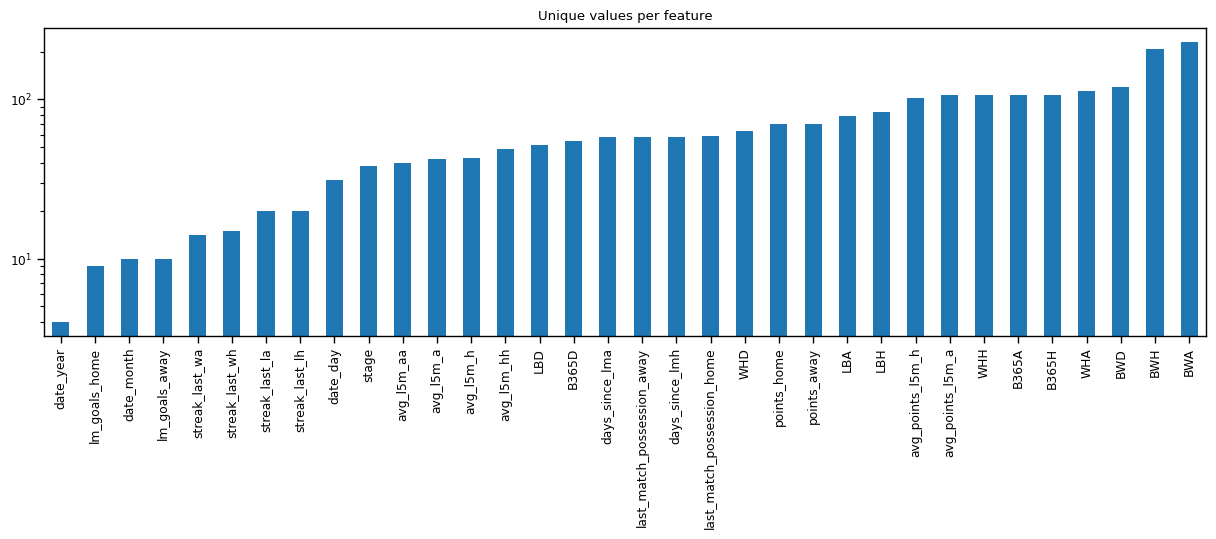

In [94]:
unique_values = df_num.nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15,4), title='Unique values per feature')
plt.show()

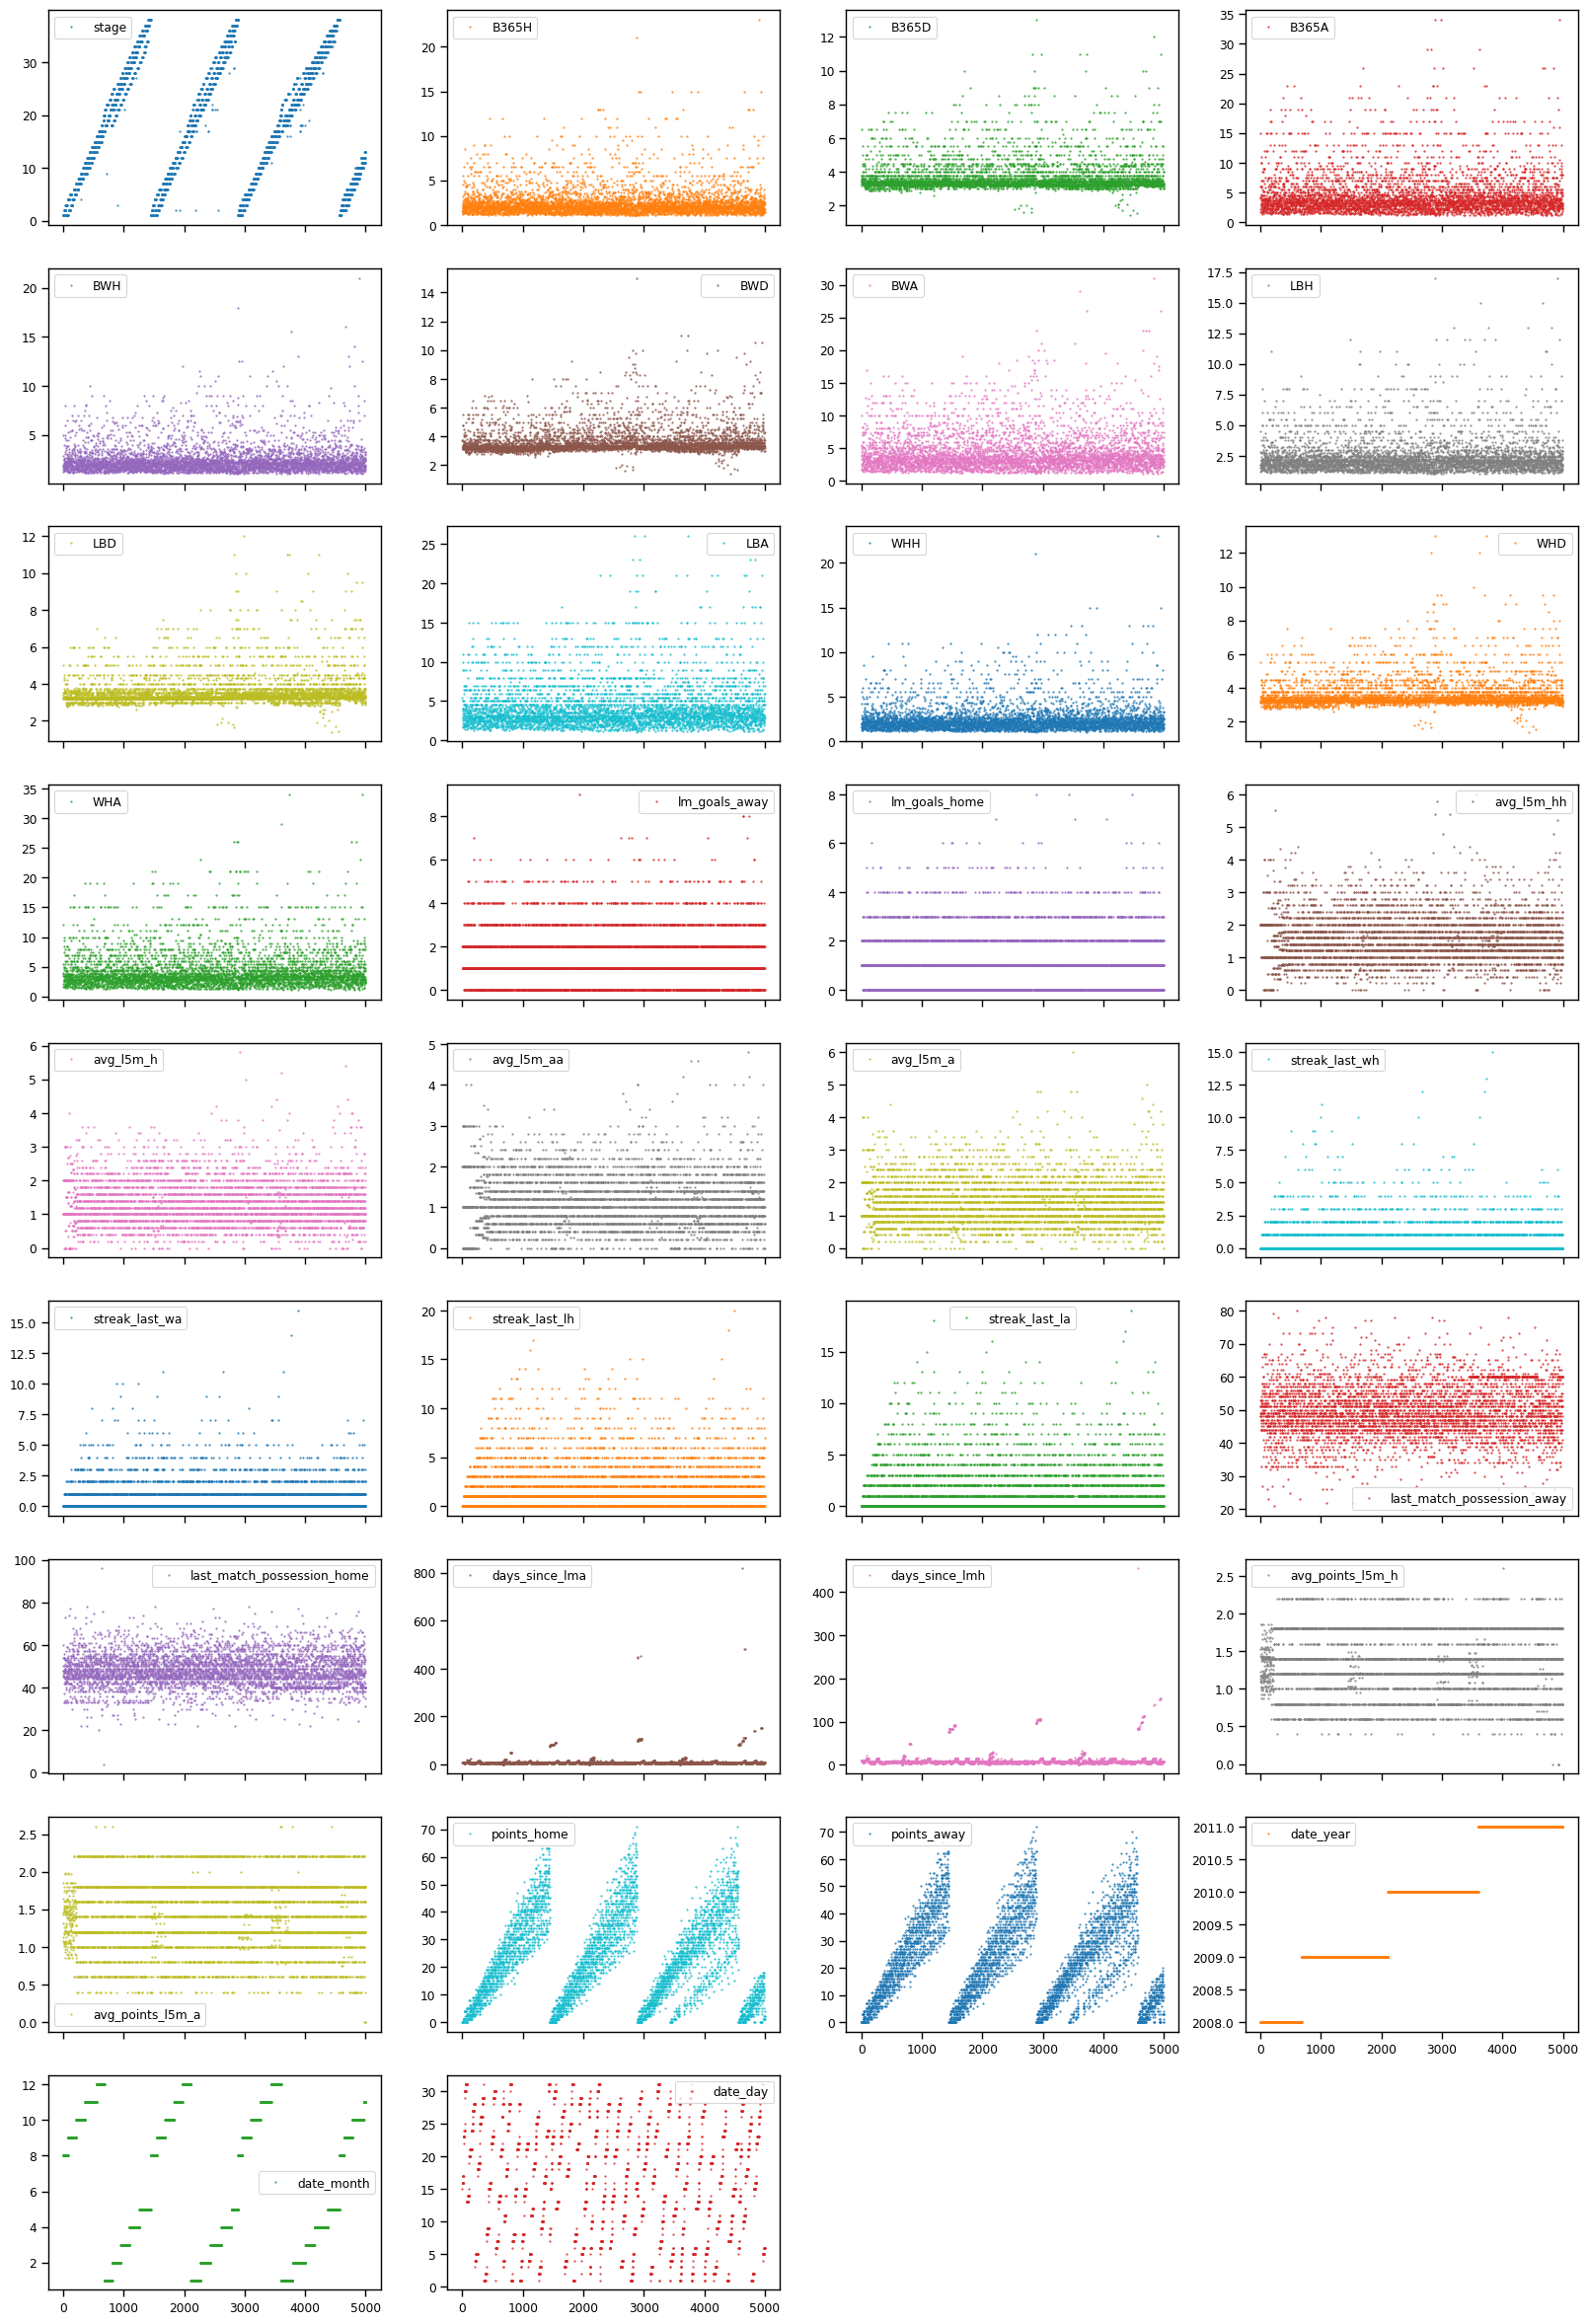

In [109]:
df_drop.plot(
    lw=0,
    marker='.',
    subplots=True,
    layout=(-1, 4),
    figsize=(20,30),
    markersize=1
)
plt.show()

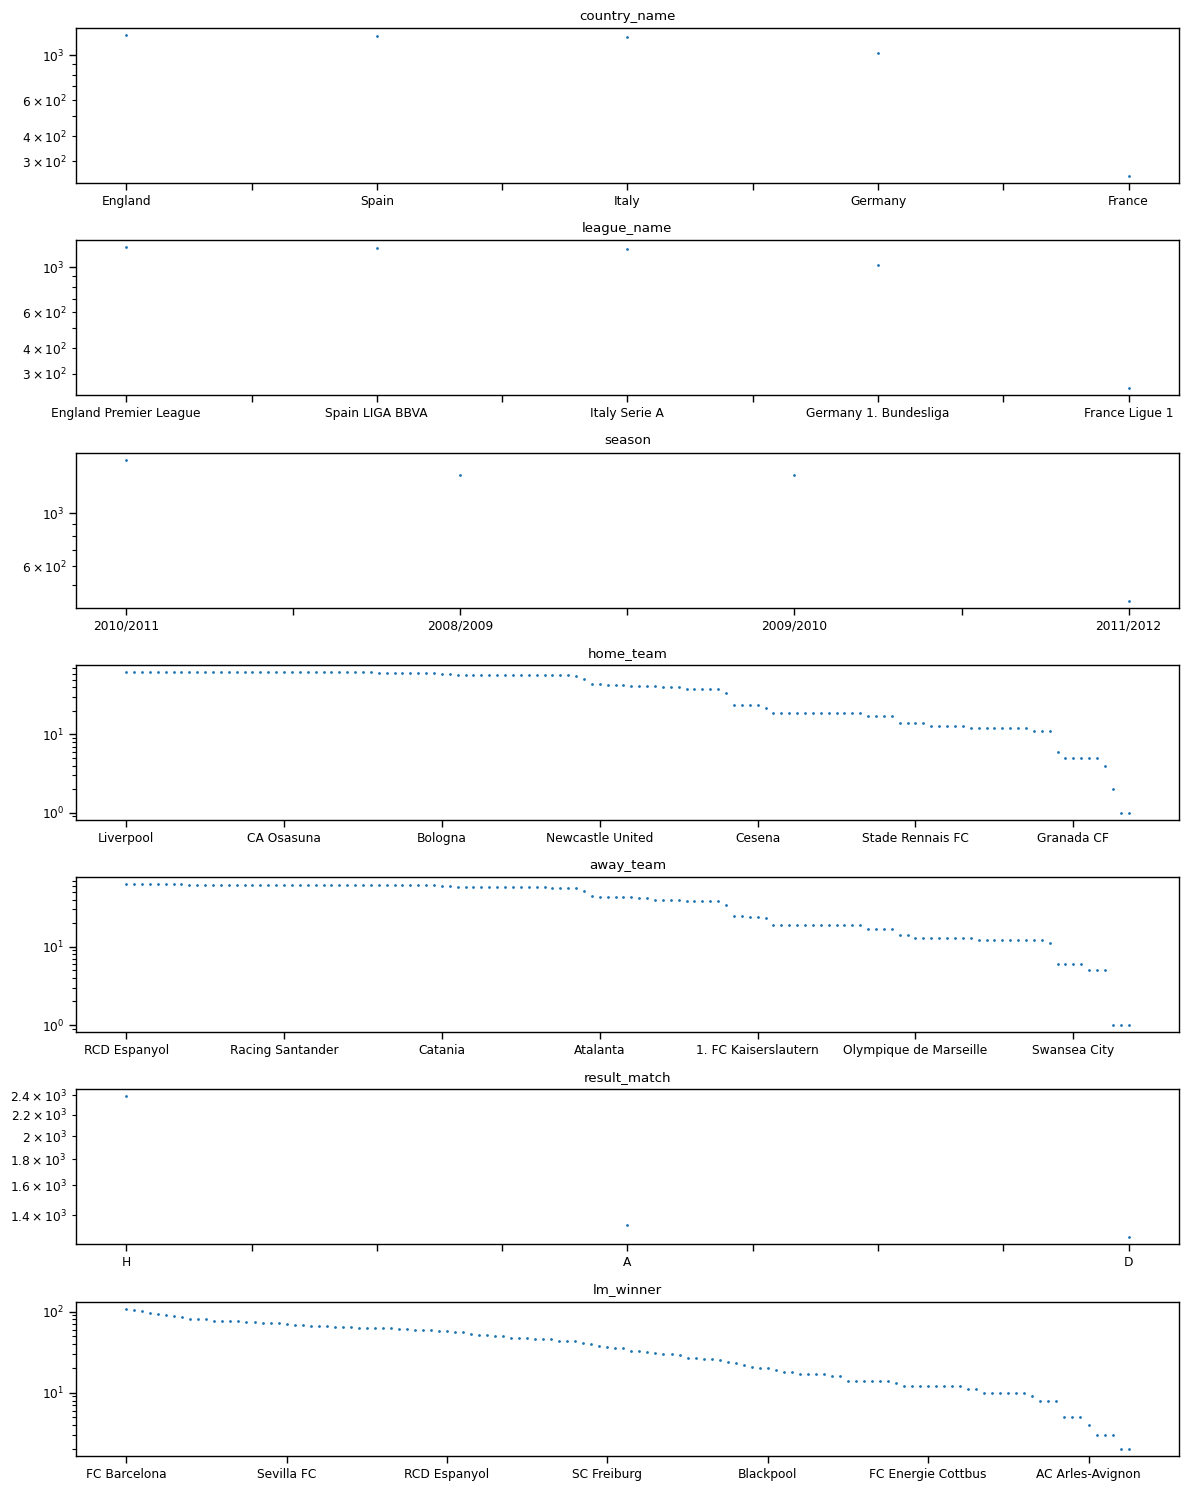

In [112]:
fig, axe = plt.subplots(ncols=1, nrows=7, figsize=(12,15))

df_non_num = df_drop.select_dtypes(exclude=['number'])

for col, ax in zip(df_non_num.columns, axe.ravel()):
    df_non_num[col].value_counts().plot(
        logy=True,
        title=col,
        lw=0,
        marker='.',
        ax=ax,
        markersize=2
    )
plt.tight_layout()
plt.show()

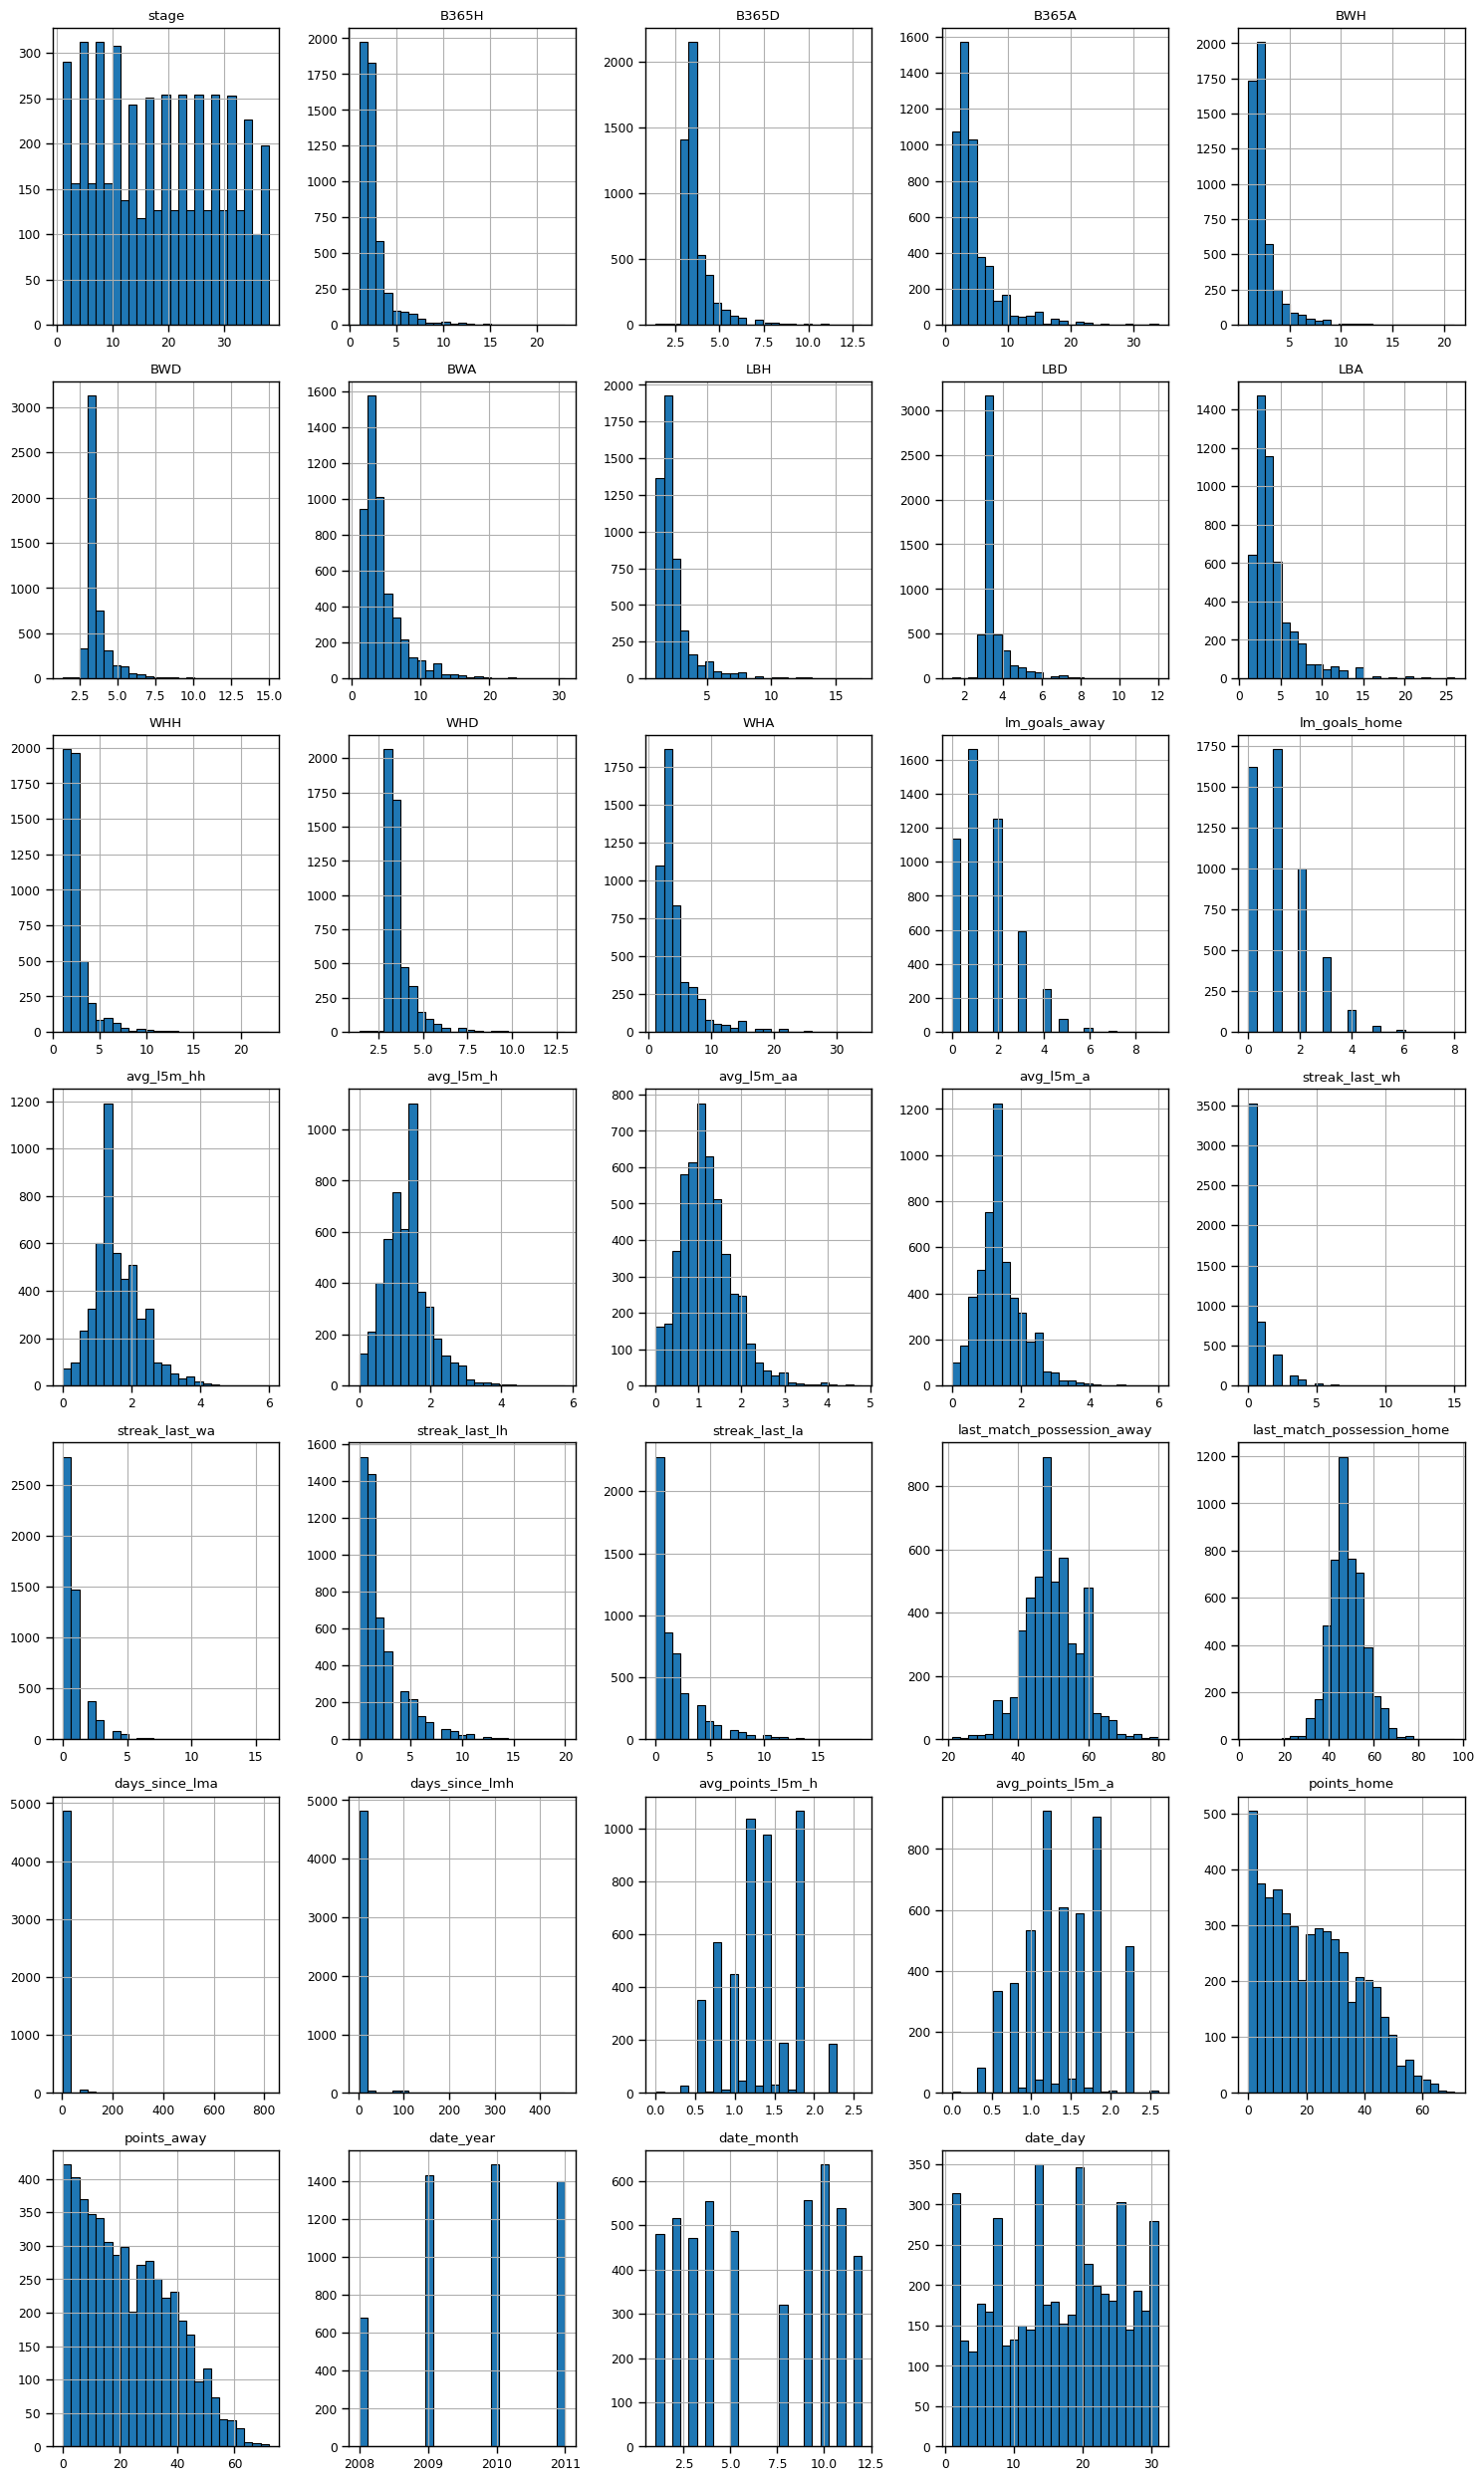

In [114]:
df_num.hist(bins=25, figsize=(15,25), layout=(-1, 5), edgecolor='black')
plt.tight_layout()
plt.show()

streak_last_wh    0.705847
streak_last_wa    0.556468
streak_last_la    0.456147
days_since_lmh    0.375250
days_since_lma    0.375250
dtype: float64

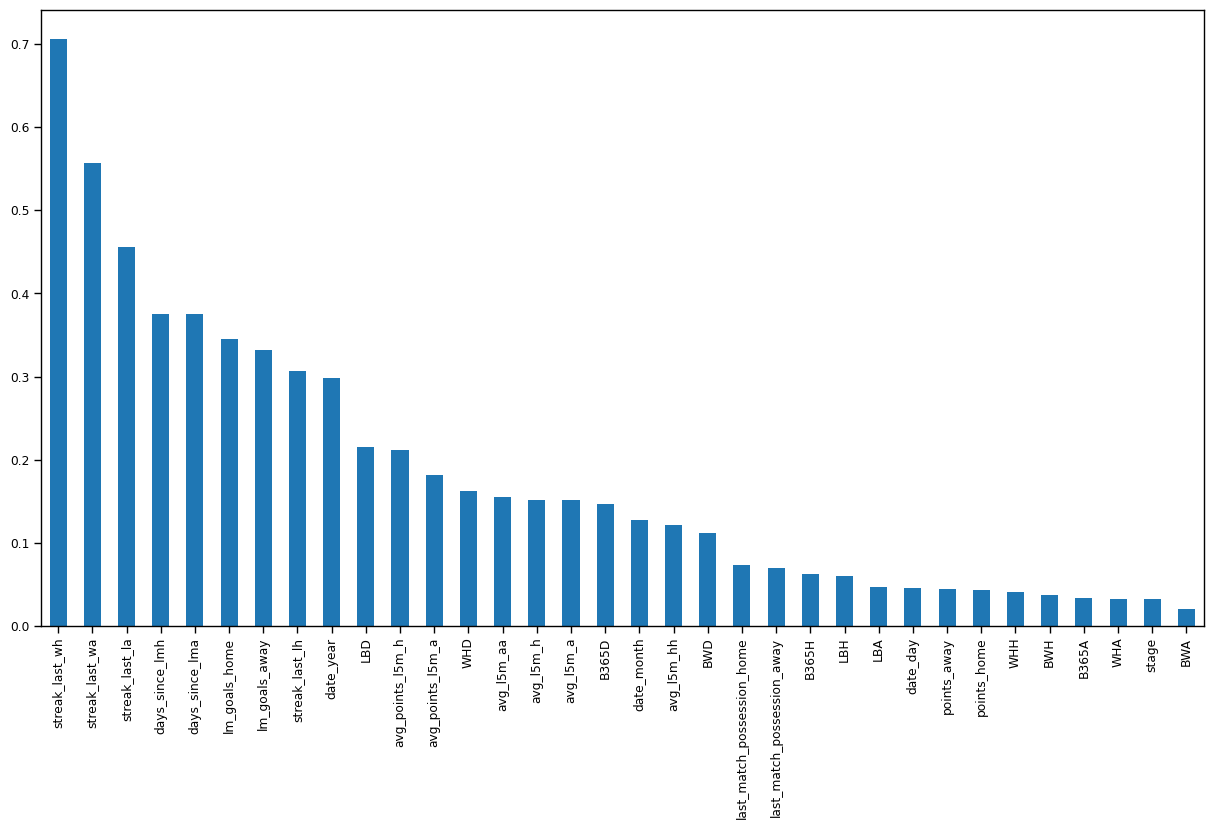

In [121]:
most_frequent_entry = df_num.mode()
df_freq = df_num.eq(most_frequent_entry.values, axis=1)
df_freq = df_freq.mean().sort_values(ascending=False)

display(df_freq.head())
df_freq.plot.bar(figsize=(15,8))
plt.show()